In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
# Constants in SI units
q = 1.60217662e-19      # Elementary charge (C)
m_e = 9.10938356e-31    # Electron mass (kg)
eps0 = 8.85418782e-12   # Vacuum permittivity (F/m)
hbar = 1.0545718e-34    # Reduced Planck constant (J.s)
k_B = 1.380649e-23      # Boltzmann constant (J/K)

In [53]:
# ---------------------------------------------
# Define functions for material parameters
# ---------------------------------------------
def a_func(x):
    a = 3.189 + (3.112 - 3.189) * x  # Lattice constant a (Angstrom)
    # print(f"Lattice constant a: {a:.5f} Å")
    return (3.189 + (3.112 - 3.189) * x) * 1e-10  # Lattice constant a (m)

def c_func(x):
    c = 5.185 + (4.982 - 5.185) * x  # Lattice constant c (Angstrom)
    # print(f"Lattice constant c: {c:.5f} Å")
    return (5.185 + (4.982 - 5.185) * x) * 1e-10  # Lattice constant c (m)

def m_star_func(x):
    return (0.2 + (0.4 - 0.2) * x) * m_e  # Effective mass (kg)

def epsilon_s_func(x):
    return 8.9 + (8.5 - 8.9) * x  # Static dielectric constant

def Volume_unitcell_func(x):
    vol = (np.sqrt(3) / 2) * a_func(x)**2 * c_func(x)  # Unit cell volume (m³)
    # print(f"Volume of unit cell: {vol:.5e} m³")
    return vol


# ---------------------------------------------
# Function 1: Interface Roughness Scattering (IRF)
# ---------------------------------------------
def mobility_irf(T, n_2DEG, L, delta, m_star, epsilon_s):
    """
    Calculate mobility limited by interface roughness scattering.
    Parameters:
        T: Temperature (K)
        n_2DEG: 2D carrier density (m^-2)
        L: Roughness length scale (m)
        delta: Roughness amplitude (m)
        m_star: Effective mass (kg)
        epsilon_s: Static dielectric constant (dimensionless)
    """
    k_F = np.sqrt(2 * np.pi * n_2DEG)  # Fermi wavevector (1/m)
    q_TF = (m_star * q**2) / (2 * np.pi * epsilon_s * eps0 * hbar**2)  # Thomas-Fermi wavevector (1/m)
    
    # Define screening function
    def G(q, b):
        return (1 / 8) * ((2 * (b / (b + q))**3) + 3 * (b / (b + q))**2 + 3 * (b / (b + q)))
    
    b = np.cbrt(33 * m_star * (q**2) * n_2DEG / (8 * (hbar**2) * eps0 * epsilon_s))
    
    # Define integrand for scattering
    def integrand(u):
        numerator = u**4 * np.exp(-(L * k_F * u)**2)
        denominator = (u + q_TF * G(u, b) / (2 * k_F))**2 * np.sqrt(1 - u**2)
        return numerator / denominator
    
    integral, _ = quad(integrand, 0, 1)
    
    # Calculate inverse relaxation time (1/tau)
    tau_ifr_inv = (m_star * (q**2 * delta * L * n_2DEG)**2 / (8 * (eps0 * epsilon_s)**2 * hbar**3)) * integral
    
    # Calculate mobility
    mu_irf = q / (tau_ifr_inv * m_star)
    return mu_irf * 1e4  # Convert to cm^2/(V·s)


# ---------------------------------------------
# Function 2: Optical Phonon Scattering (POP)
# ---------------------------------------------
def mobility_pop(T, n_2DEG, omega_0, epsilon_s, epsilon_inf, m_star):
    """
    Calculate mobility limited by polar optical phonon scattering.
    Parameters:
        T: Temperature (K)
        n_2DEG: 2D carrier density (m^-2)
        omega_0: Optical phonon frequency (rad/s)
        epsilon_s: Static dielectric constant (dimensionless)
        epsilon_inf: High-frequency dielectric constant (dimensionless)
        m_star: Effective mass (kg)
    """
    eps_p = 2 / ((1 / epsilon_s) + (1 / epsilon_inf))  # Harmonic mean of dielectric constants
    Q0 = np.sqrt(2 * m_star * (hbar * omega_0) / hbar**2)
    z = np.pi * hbar**2 * n_2DEG / (m_star * q * T * k_B)
    
    # Bose-Einstein distribution function
    N_B = 1 / (np.exp(hbar * omega_0 / (k_B * T)) - 1)
    
    # Screening form factor G(Q0)
    b = 8
    G_Q0 = b * (8 * b**2 + 9 * Q0 * b + 3 * Q0**2) / (8 * (Q0 + b)**3)
    
    # Mobility formula
    mu_pop = (2 * Q0 * hbar**2 * (1 + (1 - np.exp(-z)) / z) * eps0 * eps_p) / (q * m_star**2 * omega_0 * N_B * G_Q0)
    return mu_pop * 1e4  # Convert to cm^2/(V·s)


# ---------------------------------------------
# Function 3: Background Impurity Scattering
# ---------------------------------------------
def mobility_imp(T, n_2DEG, N_imp, epsilon_s, m_star):
    """
    Calculate mobility limited by impurity scattering.
    Parameters:
        T: Temperature (K)
        n_2DEG: 2D carrier density (m^-2)
        N_imp: Impurity density (m^-3)
        epsilon_s: Static dielectric constant (dimensionless)
        m_star: Effective mass (kg)
    """
    prefactor = (
        4 * (2 * np.pi)**(5 / 2) * hbar**3 * (eps0 * epsilon_s)**2
    ) / ((m_star**2) * q**3)
    
    # Mobility formula
    mu_imp = prefactor * (n_2DEG**(3 / 2) / N_imp)
    return mu_imp * 1e4  # Convert to cm^2/(V·s)


# ---------------------------------------------
# Function 4: Dislocation Scattering
# ---------------------------------------------
def mobility_dislocation(T, n_2DEG, N_DIS, f_DIS, m_star, q, epsilon_0, epsilon_s, c0):
    """
    Calculate mobility limited by dislocation scattering.

    Parameters:
        n_2DEG (float): 2D carrier density (m^-2).
        N_DIS (float): Density of dislocation scattering centers (m^-2).
        f_DIS (float): Form factor (dimensionless).
        m_star (float): Effective mass of the electron (kg).
        q (float): Elementary charge (C).
        epsilon_0 (float): Vacuum permittivity (F/m).
        epsilon_s (float): Static dielectric constant.
        c0 (float): Lattice constant (m).

    Returns:
        float: Mobility limited by dislocation scattering (cm^2/V·s).
    """

    # Derived parameters
    k_F = np.sqrt(2 * np.pi * n_2DEG)  # Fermi wavevector (1/m)
    q_TF = (m_star * q**2) / (2 * np.pi * epsilon_s * epsilon_0 * hbar**2)  # Thomas-Fermi wavevector (1/m)

    # Define the integrand
    def integrand(u):
        return 1 / ((u + q_TF / (2 * k_F))**2 * np.sqrt(1 - u**2))

    # Perform the integration
    integral_result = quad(integrand, 0, 1)

    # Scattering rate calculation
    scattering_rate = (
        (q**4 * m_star * N_DIS * f_DIS**2) /
        (c0**2 * (epsilon_0 * epsilon_s)**2 * hbar**3 * 4 * np.pi * k_F**4)
    ) * float(integral_result[0])

    # Scattering time (τ_DIS)
    scattering_time = 1 / scattering_rate

    # Mobility calculation
    mobility = (q * scattering_time) / m_star  # Mobility in m^2/V·s
    return mobility * 1e4  # Convert to cm^2/V·s


# ---------------------------------------------
# Function 5: Alloy Disorder Scattering
# ---------------------------------------------

def mobility_alloy_disorder(T, n_2DEG, x, m_star, epsilon_s, Volume_unitcell, delta_V0=2.0 * 1.6e-19):
    
    """
    Calculate the mobility limited by alloy disorder scattering.

    Parameters:
        T (float): Temperature (K).
        x (float): Alloy fraction (dimensionless, between 0 and 1).
        n_2DEG (float): 2D electron concentration (cm^-2).
        delta_V0 (float): Alloy disorder potential energy (J), default is 2.0 eV.

    Returns:
        float: Mobility limited by alloy disorder scattering (cm^2/V·s).
    """
    b = (33 * q**2 * m_star * n_2DEG / (8 * eps0 * epsilon_s * hbar**2))**(1/3)
    
    # Calculate mobility
    numerator = q * hbar**3 * 16
    denominator = (m_star * delta_V0)**2 * Volume_unitcell * (1 - x) * x * 3 * b
    mobility = numerator / denominator
    
    return mobility * 1e4  # Convert to cm²/V·s


# ---------------------------------------------
# Function 6: Remote Impurity Scattering
# ---------------------------------------------

def impurity_scattering_mobility(T, n_2DEG, n_imp, d):
    """
    Calculate and plot mobility due to impurity scattering as a function of distance between 2D electron gas and impurities.

    Parameters:
        T (float): Temperature (K).
        n_2DEG (float): 2D electron gas concentration (m^-2).
        n_imp (float): Impurity concentration (m^-2).
        d (float): Distance between 2D electron gas and impurities (m).

    Returns:
        float: Mobility limited by alloy disorder scattering (cm^2/V·s).

    """
    
    # Calculate Fermi wavevector
    k_F = np.sqrt(2 * np.pi * n_2DEG)
    
    # Define mobility calculation
    mobility =  (8 * q / (np.pi * hbar)) * (k_F * d)**3 / n_imp

    return mobility * 1e4  # Convert to cm²/V·s


def mobility_combined_func(T, n_2DEG, x, N_imp, N_dis, f_dis, N_imp_ionized, N_imp_barrier, d_ionized, d_imp_barrier, delta_V0, L, delta, omega_0):
    """
    Calculate the combined mobility of a 2D electron gas due to various scattering mechanisms.

    Parameters:
        T (float): Temperature (K).
        n_2DEG (float): 2D electron gas concentration (m^-2).
        x (float): Alloy fraction (dimensionless, between 0 and 1).
        N_imp (float): Impurity density (m^-3).
        N_dis (float): Dislocation density (m^-2).
        f_dis (float): Form factor (dimensionless).
        N_imp_ionized (float): Ionized impurity density (m^-2).
        d_ionized (float): Distance between 2D electron gas and ionized impurities (m).
        delta_V0 (float): Alloy disorder potential energy (J).

    Returns:
        float: Combined mobility of a 2D electron gas (cm^2/V·s).
    """
    # Calculate material parameters
    m_star = m_star_func(x)
    epsilon_s = epsilon_s_func(x)  # Static dielectric constant

    # Calculate mobilities due to different scattering mechanisms
    mu_irf = mobility_irf(T, n_2DEG, L, delta, m_star, epsilon_s)
    mu_imp = mobility_imp(T, n_2DEG, N_imp, epsilon_s, m_star)
    mu_dis = mobility_dislocation(T, n_2DEG, N_dis, f_dis, m_star, q, eps0, epsilon_s, c_func(x))
    mu_pop = mobility_pop(T, n_2DEG, omega_0, epsilon_s, epsilon_s, m_star)
    mu_alloy = mobility_alloy_disorder(T, n_2DEG, x, m_star, epsilon_s, Volume_unitcell_func(x), delta_V0)
    mu_remote_imp = impurity_scattering_mobility(T, n_2DEG, N_imp_ionized, d_ionized)
    mu_remote_imp_barrier = impurity_scattering_mobility(T, n_2DEG, N_imp_barrier, d_imp_barrier)

    # Calculate the combined mobility
    mu_combined_inv = 1 / mu_irf + 1 / mu_imp + 1 / mu_dis + 1 / mu_pop + 1 / mu_alloy + 1 / mu_remote_imp + 1/mu_remote_imp_barrier
    mu_combined = 1 / mu_combined_inv

    return mu_combined

In [83]:
# Example usage:
x = 0.65

T = 300  # Temperature (K)
m_star = m_star_func(x)
epsilon_s = epsilon_s_func(x)  # Static dielectric constant


n_2DEG = 1e17           # Carrier density (m^-2)
N_imp = 5e20            # Impurity density (m^-3)
omega_0 = 1.4585e+14    # Optical phonon frequency (rad/s)

L = 20e-10  # Roughness length scale (m)
delta = 3e-10  # Roughness amplitude (m)

N_dis = 1e12  # Dislocation density (m^-2)
f_dis = 0.5  # Form factor


N_imp_ionized = 1e17  # Ionized impurity density (m^-2)
d_ionized = 150e-9  # Distance between 2D electron gas and ionized impurities (m)

delta_V0 = 1.5 * 1.6e-19  # Alloy disorder potential energy (J)

N_imp_barrier = 1e24*20e-9  # Impurity density (m^-2)
d_imp_barrier = 1.5e-9  # Distance between 2D electron gas and impurities (m)

print("Mobility (IRF):", mobility_irf(T, n_2DEG, L, delta, m_star, epsilon_s), "cm^2/Vs")
print("Mobility (Background Impurity):", mobility_imp(T, n_2DEG, N_imp, epsilon_s, m_star), "cm^2/Vs")
print("Mobility (Dislocation):", mobility_dislocation(T, n_2DEG, N_dis, f_dis, m_star, q, eps0, epsilon_s, c_func(x)), "cm^2/Vs")
print("Mobility (POP):", mobility_pop(T, n_2DEG, omega_0, epsilon_s, epsilon_s, m_star), "cm^2/Vs")
print(f"Mobility (Alloy Disorder) (x={x}): {mobility_alloy_disorder(T, n_2DEG, x, m_star_func(x), epsilon_s_func(x), Volume_unitcell_func(x), delta_V0)} cm^2/V·s")
print("Mobility (Remote Impurity):", impurity_scattering_mobility(T, n_2DEG, N_imp_ionized, d_ionized), "cm^2/Vs")
print("Mobility (Remote Impurity Barrier):", impurity_scattering_mobility(T, n_2DEG, N_imp_barrier, d_imp_barrier), "cm^2/Vs")

# print("Mobility (Remote Impurity):", impurity_scattering_mobility(T, n_2DEG, N_imp_ionized, 180e-9), "cm^2/Vs")



Mobility (IRF): 14439.989414231059 cm^2/Vs
Mobility (Background Impurity): 4623342.180486793 cm^2/Vs
Mobility (Dislocation): 1232530.457592854 cm^2/Vs
Mobility (POP): 89324682920.12561 cm^2/Vs
Mobility (Alloy Disorder) (x=0.65): 126.43399297346217 cm^2/V·s
Mobility (Remote Impurity): 650306253.2416193 cm^2/Vs
Mobility (Remote Impurity Barrier): 3251.5312662080973 cm^2/Vs


In [84]:
mobility_combined_func(T, n_2DEG, x, N_imp, N_dis, f_dis, N_imp_ionized, N_imp_barrier,d_ionized, d_imp_barrier, delta_V0, L, delta, omega_0)

120.6695606419348

In [85]:
mobility_combined = 1 / (1/mobility_irf(T, n_2DEG, L, delta, m_star, epsilon_s) 
                         + 1/mobility_imp(T, n_2DEG, N_imp, epsilon_s, m_star) 
                         + 1/mobility_dislocation(T, n_2DEG, N_dis, f_dis, m_star, q, eps0, epsilon_s, c_func(x)) 
                         + 1/mobility_pop(T, n_2DEG, omega_0, epsilon_s, epsilon_s, m_star) 
                         + 1/mobility_alloy_disorder(T, n_2DEG, x, m_star_func(x), epsilon_s_func(x), Volume_unitcell_func(x), delta_V0)
                         + 1/impurity_scattering_mobility(T, n_2DEG, N_imp_ionized, d_ionized))
            

In [86]:
mobility_combined

125.32040256179037

In [95]:
N_imp_ionized_arr = np.linspace(1e16, 2e19, 1000)
n_DEG_arr = np.array([6e16, 8e16, 1e17])


In [99]:
mobility = []
u_remote_impurity_arr = []
u_dislocation_arr = []
u_background_impurity_arr = []
u_alloy_arr = []
u_pop_arr = []
u_irf_arr = []
u_remote_barrier_arr = []

for n_2DEG in n_DEG_arr:
    mobility.append(mobility_combined_func(T, n_2DEG, x, N_imp, N_dis, f_dis, N_imp_ionized_arr, N_imp_barrier,d_ionized, d_imp_barrier, delta_V0, L, delta, omega_0))
    u_remote_impurity_arr.append(impurity_scattering_mobility(T, n_2DEG, N_imp_ionized_arr, d_ionized))
    u_dislocation_arr.append(mobility_dislocation(T, n_2DEG, N_dis, f_dis, m_star, q, eps0, epsilon_s, c_func(x)))
    u_background_impurity_arr.append(mobility_imp(T, n_2DEG, N_imp, epsilon_s, m_star))
    u_alloy_arr.append(mobility_alloy_disorder(T, n_2DEG, x, m_star_func(x), epsilon_s_func(x), Volume_unitcell_func(x), delta_V0))
    u_pop_arr.append(mobility_pop(T, n_2DEG, omega_0, epsilon_s, epsilon_s, m_star))
    u_irf_arr.append(mobility_irf(T, n_2DEG, L, delta, m_star, epsilon_s))
    u_remote_barrier_arr.append(impurity_scattering_mobility(T, n_2DEG, 5e24/20e-9, 1e-9))        # Remote Ionization Scattering

In [100]:
u_dislocation_arr

[635975.9472648838, 921113.6918584338, 1232530.457592854]

In [102]:
np.shape(mobility)

(3, 1000)

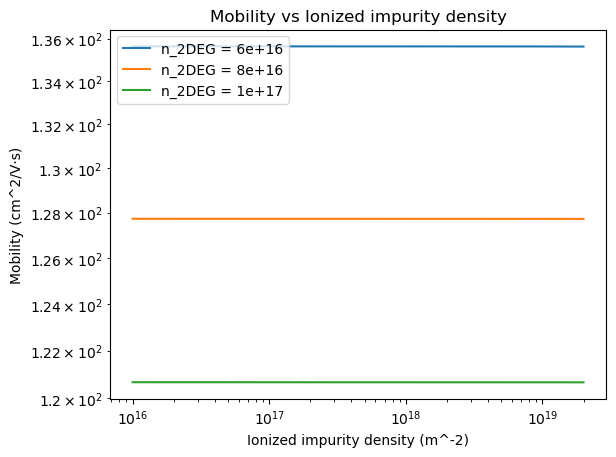

In [109]:
plt.close()
plt.figure()
for i in range(np.shape(mobility)[0]):
    plt.plot(N_imp_ionized_arr, mobility[i], label=f'n_2DEG = {n_DEG_arr[i]}')
    # plt.plot(N_imp_ionized_arr, u_remote_impurity_arr[i], label='Remote Impurity')
    # plt.plot(N_imp_ionized_arr, np.repeat(u_dislocation_arr[i], 100), label='Dislocation')
    # plt.plot(N_imp_ionized_arr, np.repeat(u_background_impurity_arr[i], 100), label='Background Impurity')
    # plt.plot(N_imp_ionized_arr, np.repeat(u_alloy_arr[i], 100), label='Alloy Disorder')
    # plt.plot(N_imp_ionized_arr, np.repeat(u_pop_arr[i], 100), label='POP')
    # plt.plot(N_imp_ionized_arr, np.repeat(u_irf_arr[i], 100), label='IRF')

plt.xlabel('Ionized impurity density (m^-2)')
plt.ylabel('Mobility (cm^2/V·s)')
plt.title('Mobility vs Ionized impurity density')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()